In [ ]:
import kagglehub
import os
import pickle
import numpy as np
import pandas as pd
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

################################################################
#       CHANGE THIS TO YOUR LOCAL DIRECTORY PATH               #
dir_path = '/content/drive/MyDrive/COSC 760 project/3. GCN-LSTM'
################################################################

model_name = 'GCN-LSTM'

In [ ]:
def normalize_adj(adj, eps=1e-5):
    A = adj + torch.eye(adj.size(0), device=adj.device)
    D = A.sum(-1)
    D_inv_sqrt = (D + eps).pow(-0.5)
    A_norm = D_inv_sqrt[:, None] * A * D_inv_sqrt[None, :]
    return A_norm

# -------------------------
# Bottleneck GCN block (per-time-step)
# -------------------------
class BottleneckGCN(nn.Module):
    """
    in_ch -> reduce to bottleneck (gcn_channels) -> graph mixing -> expand to out_ch
    """
    def __init__(self, in_ch, gcn_channels, out_ch, adj, bias=True):
        super().__init__()
        self.register_buffer("A_hat", normalize_adj(adj))  # (N,N)
        self.reduce = nn.Linear(in_ch, gcn_channels, bias=True)

        # weight for mixing inside bottleneck (learnable linear transform)
        self.gc_weight = nn.Parameter(torch.randn(gcn_channels, gcn_channels) * (1.0 / (gcn_channels**0.5)))

        self.expand = nn.Linear(gcn_channels, out_ch, bias=bias)
        self.act = nn.ReLU()

        # if residual projection needed (in_ch -> out_ch)
        if in_ch != out_ch:
            self.res_proj = nn.Linear(in_ch, out_ch, bias=False)
        else:
            self.res_proj = None

    def forward(self, x):
        # x: (B, T, N, F)
        skip = x  # keep for residual
        H = self.reduce(x)                              # (B, T, N, gcn_channels)
        # spatial mixing per time-step
        H = torch.einsum("ij,btjc->btic", self.A_hat, H)  # (B, T, N, gcn_channels)
        # channel mixing inside bottleneck
        H = torch.einsum("btic,cd->btid", H, self.gc_weight)  # (B, T, N, gcn_channels)
        H = self.expand(H)                               # (B, T, N, out_ch)

        if self.res_proj is not None:
            skip = self.res_proj(skip)
        out = self.act(H + skip)
        return out  # (B, T, N, out_ch)

# -------------------------
# Spatial encoder: stack of BottleneckGCN layers (can be 1..K)
# -------------------------
class SpatialEncoder(nn.Module):
    def __init__(self, in_ch, gcn_channels, out_ch, adj, num_layers=2, dropout=0.0):
        super().__init__()
        layers = []
        # first layer: from in_ch -> out_ch via bottleneck
        layers.append(BottleneckGCN(in_ch, gcn_channels, out_ch, adj, bias=True))
        for _ in range(num_layers - 1):
            layers.append(BottleneckGCN(out_ch, gcn_channels, out_ch, adj, bias=True))
        self.layers = nn.ModuleList(layers)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        # x: (B, T, N, F)
        H = x
        for l in self.layers:
            H = l(H)
            H = self.dropout(H)
        return H  # (B, T, N, out_ch)

# -------------------------
# Full GCN-LSTM model (per-node LSTM)
# -------------------------
class GCN_LSTM(nn.Module):
    def __init__(
        self,
        adj,
        input_size=1,
        gcn_channels=16,   # bottleneck size
        gcn_out=16,        # per-node embedding size produced by spatial encoder
        lstm_hidden=64,
        num_layers=1,
        horizon=3,
        output_size=1,
        spatial_layers=2,
        dropout=0.0,
    ):
        """
        adj: (N,N) adjacency tensor
        input_size: feature channels per node (usually 1)
        gcn_channels: bottleneck channels inside GCN
        gcn_out: output channels per node from spatial encoder (used as LSTM input dim)
        lstm_hidden: LSTM hidden dim (per node)
        horizon: number of future timesteps to predict
        output_size: number of output channels per node (usually 1)
        """
        super().__init__()
        self.N = adj.shape[0]
        self.horizon = horizon
        self.output_size = output_size

        self.spatial = SpatialEncoder(in_ch=input_size,
                                      gcn_channels=gcn_channels,
                                      out_ch=gcn_out,
                                      adj=adj,
                                      num_layers=spatial_layers,
                                      dropout=dropout)

        # LSTM runs per-node (shared weights); input_size = gcn_out
        self.lstm = nn.LSTM(input_size=gcn_out,
                            hidden_size=lstm_hidden,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.0)

        # decoder -> turn LSTM hidden -> output_size (per node)
        self.decoder = nn.Linear(lstm_hidden, output_size)

    def forward(self, x):
        """
        Accepts:
          (B, N, T)
          (B, N, T, F)
          (B, T, N)
          (B, T, N, F)
        Returns:
          (B, horizon, N) when output_size == 1
          else (B, horizon, N, output_size)
        """
        # normalize common shapes
        if x.ndim == 3:
            B, a, c = x.shape
            if a == self.N:
                # (B, N, T) -> (B, T, N)
                x = x.permute(0, 2, 1).contiguous()
            elif c == self.N:
                # (B, T, N) -> ok
                pass
            else:
                raise ValueError(f"Ambiguous 3D input {x.shape}; node count {self.N} not found.")
        if x.ndim == 4:
            B, a, b, d = x.shape
            if a == self.N:
                # (B, N, T, F) -> (B, T, N, F)
                x = x.permute(0, 2, 1, 3).contiguous()
            elif b == self.N:
                # already (B, T, N, F)
                pass
            else:
                raise ValueError(f"Ambiguous 4D input {x.shape}; node count {self.N} not found.")

        # ensure last dim is features
        if x.ndim == 3:
            x = x.unsqueeze(-1)  # (B, T, N, 1)

        B, T, N, F = x.shape
        assert N == self.N, f"Node mismatch: expected {self.N}, got {N}"
        assert self.horizon <= T, f"horizon ({self.horizon}) must be <= input length T ({T})"

        # 1) spatial encoding (per timestep)
        H = self.spatial(x)  # (B, T, N, gcn_out)

        # 2) prepare per-node sequences for shared LSTM
        H = H.permute(0, 2, 1, 3).contiguous()   # (B, N, T, gcn_out)
        H = H.view(B * N, T, -1)                 # (B*N, T, gcn_out)

        # 3) run LSTM per-node
        H_lstm, _ = self.lstm(H)                 # (B*N, T, lstm_hidden)

        # 4) select final horizon steps
        H_sel = H_lstm[:, -self.horizon:, :]     # (B*N, horizon, lstm_hidden)

        # 5) decode per-node
        out = self.decoder(H_sel)                # (B*N, horizon, output_size)

        # 6) reshape back: (B, horizon, N, output_size)
        out = out.view(B, N, self.horizon, self.output_size)
        out = out.permute(0, 2, 1, 3).contiguous()  # (B, horizon, N, output_size)

        if self.output_size == 1:
            out = out.squeeze(-1)  # (B, horizon, N)

        return out

In [ ]:
metrlaKaggle = "annnnguyen/metr-la-dataset"
metrlaPklFile = 'adj_METR-LA.pkl'
metrlaH5File = 'METR-LA.h5'

agg_rule = '5min'

train_frac = 0.7
val_frac = 0.1
test_frac = 0.2

In [ ]:
def splitAndScale(df):
  print(f'\nImplementing {train_frac}:{val_frac}:{test_frac} train:validation:test split')
  n = len(df)
  n_train = int(n * train_frac)
  n_val   = int(n * val_frac)
  n_test  = n - n_train - n_val

  train_df = df.iloc[:n_train]
  val_df   = df.iloc[n_train:n_train + n_val]
  test_df  = df.iloc[n_train + n_val:]

  print('Scaling with StandardScaler()')

  scaler = StandardScaler()
  scaler.fit(train_df.values)

  train_scaled = scaler.transform(train_df.values)
  val_scaled   = scaler.transform(val_df.values)
  test_scaled  = scaler.transform(test_df.values)

  print(
  f'test shape {train_scaled.shape}\nval shape {val_scaled.shape}\ntest shape {test_scaled.shape}'
  )

  return train_scaled, val_scaled, test_scaled, scaler

In [ ]:
def impute(df):
  df = df.ffill().bfill().fillna(0)
  return df

In [ ]:
def loadAndPreprocess(name, kagglePath, pkl, h5, key):
  path = kagglehub.dataset_download(kagglePath)
  print(f'Saved {name} data to {path}')
  with open(path + '/' + pkl, 'rb') as f:
      graph_data = pickle.load(f, encoding='latin1')

  if isinstance(graph_data, list) and len(graph_data) >= 3:
      sensor_ids = graph_data[0]
      node_ids   = graph_data[1]
      adj_matrix_np = graph_data[2]
      adj_matrix = torch.tensor(adj_matrix_np, dtype=torch.float32)
  else:
      raise ValueError("Unexpected structure in the pickle file.")

  print(f"Loaded {name} graph with {len(sensor_ids)} sensors")

  df = pd.read_hdf(path + '/' + h5, key=key)
  df = df.astype('float32')
  print(f"{name} DataFrame shape:", df.shape)

  df = df.resample(agg_rule).mean()
  if np.any(np.isnan(df)):
    print('Imputing missing values')
    df = impute(df)

  print(f'Aggregated {name} dataframe into 5 minute intervals with shape: {df.shape}')

  train_df, val_df, test_df, scaler = splitAndScale(df)
  return train_df, val_df, test_df, scaler, sensor_ids, node_ids, adj_matrix

In [ ]:
train_df,   \
val_df,     \
test_df,    \
scaler,     \
sensor_ids, \
node_ids,   \
adj_matrix = loadAndPreprocess('metr-la',metrlaKaggle, metrlaPklFile, metrlaH5File, 'df')

Using Colab cache for faster access to the 'metr-la-dataset' dataset.
Saved metr-la data to /kaggle/input/metr-la-dataset
Loaded metr-la graph with 207 sensors
metr-la DataFrame shape: (34272, 207)
Aggregated metr-la dataframe into 5 minute intervals with shape: (34272, 207)

Implementing 0.7:0.1:0.2 train:validation:test split
Scaling with StandardScaler()
test shape (23990, 207)
val shape (3427, 207)
test shape (6855, 207)


In [ ]:
def make_windows(data_array, lookback=12, horizon=3, step=1):
    # data_array: (T, N) where T = timesteps, N = num_sensors/features
    X, Y = [], []
    T = data_array.shape[0]
    i = 0
    while i + lookback + horizon <= T:
        X.append(data_array[i : i + lookback])            # (lookback, N)
        Y.append(data_array[i + lookback : i + lookback + horizon])  # (horizon, N)
        i += step
    X = np.stack(X)  # (num_samples, lookback, N)
    Y = np.stack(Y)  # (num_samples, horizon, N)
    return X, Y

X_train, Y_train = make_windows(train_df)
X_val,   Y_val   = make_windows(val_df)
X_test,  Y_test  = make_windows(test_df)

In [ ]:
print(X_train.shape, Y_train.shape)

(23976, 12, 207) (23976, 3, 207)


In [ ]:
class TrafficDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
train_loader = DataLoader(TrafficDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TrafficDataset(X_val,   Y_val), batch_size=64)
test_loader  = DataLoader(TrafficDataset(X_test,  Y_test), batch_size=64)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
model = GCN_LSTM(
    adj=adj_matrix,          # torch tensor (N,N)
    input_size=1,
    gcn_channels=16,
    gcn_out=16,
    lstm_hidden=64,
    num_layers=1,
    horizon=3,
    output_size=1,
    spatial_layers=2,
    dropout=0.1
).to(device)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): epochs to wait after last improvement.
            min_delta (float): minimum improvement to count as better.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.stop = True

def train(epochs, criterion, optimizer, scheduler, early_stopper, model, train_loader, val_loader, device):
  best_state = None
  best_val_loss = float('inf')

  train_loss_history = []
  val_loss_history = []

  for epoch in range(epochs):
      model.train()
      train_losses = []

      for Xbatch, Ybatch in train_loader:
          Xbatch, Ybatch = Xbatch.to(device), Ybatch.to(device)
          optimizer.zero_grad()
          pred = model(Xbatch)
          loss = criterion(pred, Ybatch)
          loss.backward()
          optimizer.step()
          train_losses.append(loss.item())

      # --------- VALIDATION --------- #
      model.eval()
      val_losses = []
      with torch.no_grad():
          for Xbatch, Ybatch in val_loader:
              Xbatch, Ybatch = Xbatch.to(device), Ybatch.to(device)
              pred = model(Xbatch)
              val_loss = criterion(pred, Ybatch)
              val_losses.append(val_loss.item())

      avg_train_loss = sum(train_losses) / len(train_losses)
      train_loss_history.append(avg_train_loss)

      avg_val_loss = sum(val_losses) / len(val_losses)
      val_loss_history.append(avg_val_loss)

      print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

      # --------- CHECK IMPROVEMENT --------- #
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          best_state = model.state_dict()
          print("> Best model updated.")

      scheduler.step(avg_val_loss)

      # --------- EARLY STOPPING --------- #
      early_stopper.step(avg_val_loss)
      if early_stopper.stop:
          print(f"Early stopping triggered at epoch {epoch+1}")
          break

  # --------- LOAD BEST MODEL --------- #
  if best_state is not None:
      model.load_state_dict(best_state)
      print("Restored best model weights.")

  return train_loss_history, val_loss_history

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.7,
    patience=3
)

early_stopper = EarlyStopping(patience=10, min_delta=1e-4)

epochs = 250

train_loss_history, val_loss_history = train(
    epochs,
    criterion,
    optimizer,
    scheduler,
    early_stopper,
    model,
    train_loader,
    val_loader,
    device
  )

Epoch 1 | Train Loss: 0.6756 | Val Loss: 0.3268
> Best model updated.
Epoch 2 | Train Loss: 0.2752 | Val Loss: 0.2683
> Best model updated.
Epoch 3 | Train Loss: 0.2448 | Val Loss: 0.2530
> Best model updated.
Epoch 4 | Train Loss: 0.2376 | Val Loss: 0.2444
> Best model updated.
Epoch 5 | Train Loss: 0.2348 | Val Loss: 0.2416
> Best model updated.
Epoch 6 | Train Loss: 0.2327 | Val Loss: 0.2379
> Best model updated.
Epoch 7 | Train Loss: 0.2314 | Val Loss: 0.2338
> Best model updated.
Epoch 8 | Train Loss: 0.2300 | Val Loss: 0.2337
> Best model updated.
Epoch 9 | Train Loss: 0.2290 | Val Loss: 0.2311
> Best model updated.
Epoch 10 | Train Loss: 0.2280 | Val Loss: 0.2302
> Best model updated.
Epoch 11 | Train Loss: 0.2270 | Val Loss: 0.2305
Epoch 12 | Train Loss: 0.2264 | Val Loss: 0.2287
> Best model updated.
Epoch 13 | Train Loss: 0.2260 | Val Loss: 0.2280
> Best model updated.
Epoch 14 | Train Loss: 0.2254 | Val Loss: 0.2285
Epoch 15 | Train Loss: 0.2248 | Val Loss: 0.2272
> Best mod

In [ ]:
def printMetrics(preds, y):
  mse = np.mean((preds - y) ** 2)
  mae = np.mean(np.abs(preds - y))
  rmse = np.sqrt(mse)
  wape = np.sum(np.abs(preds - y)) / np.sum(np.abs(y)) * 100

  print(f"Test MSE: {mse:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | WAPE: {wape:.4f}")

def plotTrainingHistory(name, train_hist, val_hist, path):
  plt.figure(figsize=(8,5))
  plt.plot(train_hist, label='Train Loss')
  plt.plot(val_hist, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.title(f'{name}: {model_name} Training & Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.savefig(f'{path}/{name}_train_val_history.png',dpi=300,bbox_inches='tight')
  plt.show()

def plotSample(name, sensor_idx, horizon_idx, preds, y, path):
  plt.figure(figsize=(12,4))
  plt.plot(preds[:, horizon_idx, sensor_idx], label='Prediction')
  plt.plot(y[:, horizon_idx, sensor_idx], label='Ground Truth')
  plt.xlabel('Sample')
  plt.ylabel('Traffic Speed')
  plt.title(f'{name}: Sensor {sensor_idx} - Horizon {horizon_idx+1}')
  plt.legend()
  plt.savefig(f'{path}/{name}_pred_vs_groundtruth.png',dpi=300,bbox_inches='tight')
  plt.show()

def evaluate(name, model, scaler, test_loader, path, device):
  model.eval()
  all_preds = []

  with torch.no_grad():
      for Xbatch, _ in test_loader:
          pred = model(Xbatch.to(device))  # shape: (batch, horizon, numSensors)
          all_preds.append(pred.cpu())

  all_preds = torch.cat(all_preds, dim=0)

  num_samples, horizon, num_sensors = all_preds.shape
  all_preds_flat = all_preds.reshape(-1, num_sensors)
  Y_test_flat    = Y_test.reshape(-1, num_sensors)

  all_preds_inv = scaler.inverse_transform(all_preds_flat)
  Y_test_inv    = scaler.inverse_transform(Y_test_flat)

  all_preds_inv = all_preds_inv.reshape(num_samples, horizon, num_sensors)
  Y_test_inv    = Y_test_inv.reshape(num_samples, horizon, num_sensors)

  printMetrics(all_preds_inv, Y_test_inv)
  plotSample(name,0,0,all_preds_inv,Y_test_inv,path)

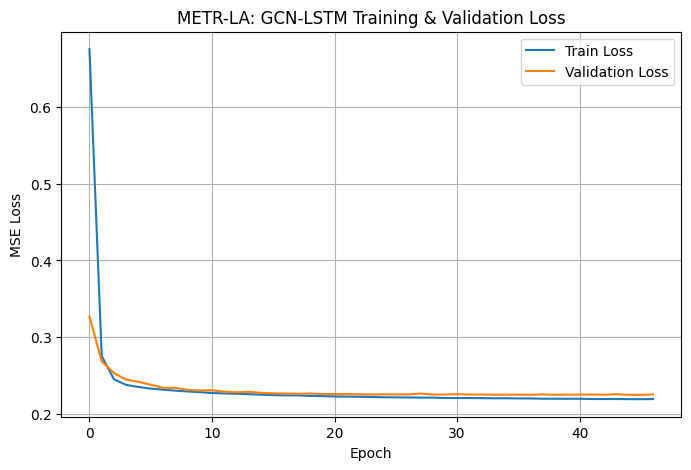

In [ ]:
plotTrainingHistory('METR-LA', train_loss_history, val_loss_history, dir_path)

Test MSE: 90.5280 | MAE: 4.8076 | RMSE: 9.5146 | WAPE: 9.4725


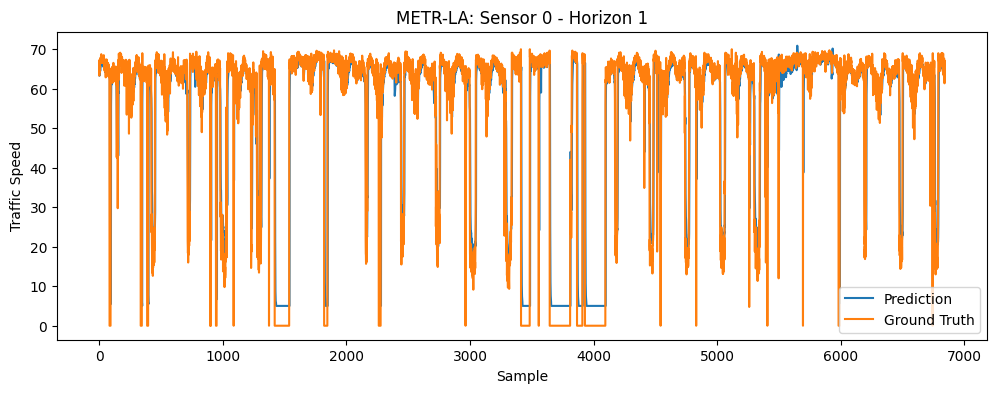

In [ ]:
evaluate('METR-LA', model, scaler, test_loader, dir_path, device)

In [ ]:
pemsbayKaggle = "scchuy/pemsbay"
pemsbayPklFile = 'adj_mx_bay.pkl'
pemsbayH5File = 'pems-bay.h5'

In [ ]:
train_df,   \
val_df,     \
test_df,    \
scaler,     \
sensor_ids, \
node_ids,   \
adj_matrix = loadAndPreprocess('pemsbay', pemsbayKaggle, pemsbayPklFile, pemsbayH5File, 'speed')

Using Colab cache for faster access to the 'pemsbay' dataset.
Saved pemsbay data to /kaggle/input/pemsbay
Loaded pemsbay graph with 325 sensors
pemsbay DataFrame shape: (52116, 325)
Imputing missing values
Aggregated pemsbay dataframe into 5 minute intervals with shape: (52128, 325)

Implementing 0.7:0.1:0.2 train:validation:test split
Scaling with StandardScaler()
test shape (36489, 325)
val shape (5212, 325)
test shape (10427, 325)


In [ ]:
X_train, Y_train = make_windows(train_df)
X_val,   Y_val   = make_windows(val_df)
X_test,  Y_test  = make_windows(test_df)

In [ ]:
train_loader = DataLoader(TrafficDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TrafficDataset(X_val,   Y_val), batch_size=64)
test_loader  = DataLoader(TrafficDataset(X_test,  Y_test), batch_size=64)

In [ ]:
model = GCN_LSTM(
    adj=adj_matrix,
    input_size=1,
    gcn_channels=16,
    gcn_out=16,
    lstm_hidden=64,
    num_layers=1,
    horizon=3,
    output_size=1,
    spatial_layers=2,
    dropout=0.1
).to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.7,
    patience=3
)

early_stopper = EarlyStopping(patience=10, min_delta=1e-4)

epochs = 250

start = time.time()

train_loss_history, val_loss_history = train(
    epochs,
    criterion,
    optimizer,
    scheduler,
    early_stopper,
    model,
    train_loader,
    val_loader,
    device
  )

computation_time = time.time() - start

Epoch 1 | Train Loss: 0.5051 | Val Loss: 0.3656
> Best model updated.
Epoch 2 | Train Loss: 0.2239 | Val Loss: 0.2776
> Best model updated.
Epoch 3 | Train Loss: 0.1935 | Val Loss: 0.2506
> Best model updated.
Epoch 4 | Train Loss: 0.1836 | Val Loss: 0.2394
> Best model updated.
Epoch 5 | Train Loss: 0.1780 | Val Loss: 0.2332
> Best model updated.
Epoch 6 | Train Loss: 0.1744 | Val Loss: 0.2289
> Best model updated.
Epoch 7 | Train Loss: 0.1716 | Val Loss: 0.2261
> Best model updated.
Epoch 8 | Train Loss: 0.1693 | Val Loss: 0.2234
> Best model updated.
Epoch 9 | Train Loss: 0.1673 | Val Loss: 0.2229
> Best model updated.
Epoch 10 | Train Loss: 0.1657 | Val Loss: 0.2202
> Best model updated.
Epoch 11 | Train Loss: 0.1644 | Val Loss: 0.2190
> Best model updated.
Epoch 12 | Train Loss: 0.1633 | Val Loss: 0.2182
> Best model updated.
Epoch 13 | Train Loss: 0.1623 | Val Loss: 0.2163
> Best model updated.
Epoch 14 | Train Loss: 0.1613 | Val Loss: 0.2171
Epoch 15 | Train Loss: 0.1605 | Val L

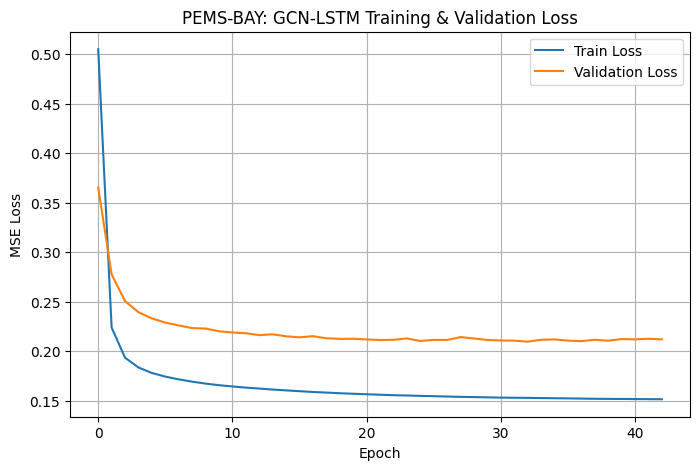

In [ ]:
plotTrainingHistory('PEMS-BAY', train_loss_history, val_loss_history, dir_path)

Test MSE: 10.9838 | MAE: 1.7358 | RMSE: 3.3142 | WAPE: 2.7788


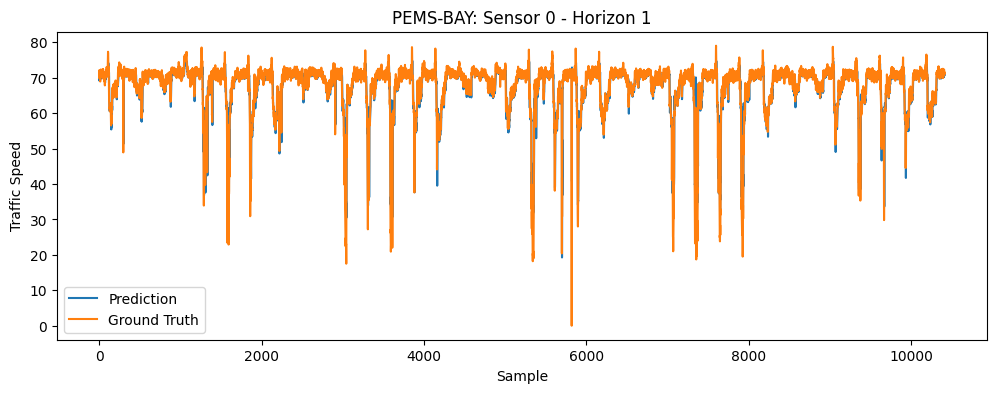

In [ ]:
evaluate('PEMS-BAY', model, scaler, test_loader, dir_path, device)